# Let's Fine Tune Mobile LLM for Chat




### Configure the machine and install packages


In [1]:
from typing import Literal

import jax

platform : Literal["darwin", "colab", "cuda"] = "darwin"

try:
    import google.colab
    platform = "colab"
except ImportError:
    devices = jax.devices()
    if any(d.platform == "gpu" for d in devices):
        platform = "cuda"

print(f"Running on {platform}")

if platform == "colab":
    !git clone https://github.com/novastar53/jaxpt
    !cd jaxpt && git checkout main && git pull
    !pip install tiktoken datasets --quiet
    !pip uninstall -y tensorflow

Running on darwin


In [2]:
from pathlib import Path
import sys

if platform == "colab":
    jaxpt_dir = str(Path().absolute() / "jaxpt" / "src" )
else:
    jaxpt_dir = str(Path().absolute().parent / "src" )


sys.path.append(jaxpt_dir)
print(jaxpt_dir)

/Users/vikram/dev/jaxpt/src


In [3]:
import os
import warnings

import jax
import flax
import jax.numpy as jnp
import numpy as np

# Hardware setup
print("JAX version:", jax.__version__)
print("Flax version", flax.__version__)
devices = jax.devices()
num_devices = len(devices)
print("Available devices:", num_devices)

requested_device = "gpu"

jax.config.update("jax_platform_name", requested_device) # Make sure we're using the GPU

device = jax.default_backend()
if device != requested_device:
    warnings.warn(f"not using {requested_device}. Using {device}")
else:
    print(f"using {device}")


#####################################
##        jax.lax matmul presets   ##
#####################################
## 'ANY_F8_ANY_F8_F32',
## 'ANY_F8_ANY_F8_F32_FAST_ACCUM'
## 'ANY_F8_ANY_F8_ANY'
## 'ANY_F8_ANY_F8_ANY_FAST_ACCUM'
## 'F16_F16_F16'
## 'F16_F16_F32'
## 'BF16_BF16_BF16'
## 'BF16_BF16_F32'
## 'BF16_BF16_F32_X3'
## 'BF16_BF16_F32_X6'
## 'TF32_TF32_F32'
## 'TF32_TF32_F32_X3'
## 'F32_F32_F32'
## 'F64_F64_F64'
#####################################

#jax.config.update("jax_default_matmul_precision", "BF16_BF16_F32") # Set the default precision for matrix multiplication

#jax.config.update("jax_enable_x64", True) # Make sure the highest precision is enabled in case we need
#os.environ["NVIDIA_TF32_OVERRIDE"] = "1"
#os.environ["JAX_ENABLE_X64"] = "False"

if device == "tpu":
    def list_tpu_memory():
        devices = jax.devices()
        for device in devices:
            if 'TPU' in str(device.device_kind):
                print(f"Device: {device}, Memory: {device.memory_stats()['bytes_limit']/(1024*1024)},  Used: {device.memory_stats()['bytes_in_use']/(1024*1024)}")

    list_tpu_memory()

# Test the device
A = jnp.array(np.random.normal(size=(4096, 4096)), dtype=jnp.float32) # Make sure matmul is fast
%timeit (A@A).block_until_ready()

JAX version: 0.5.2
Flax version 0.10.4
Available devices: 1


/var/folders/x4/85_9sn3d1ng9q48ff6t3fw340000gn/T/ipykernel_38092/3941262341.py:22: UserWarning: not using gpu. Using cpu
  warnings.warn(f"not using {requested_device}. Using {device}")


208 ms ± 19.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Initialize the Mobile-LLM model and perform a sanity check

In [4]:
from flax import nnx

from jaxpt.infer import generate_completions, generate
from jaxpt.models import Mobile_LLM, MobileLLM_Config
from jaxpt.models.mobile_llm import from_hf_pretrained
from jaxpt.utils import count_params

from transformers import AutoTokenizer

key = jax.random.PRNGKey(1337)
rngs = nnx.Rngs(key)
config = MobileLLM_Config(dtype=jnp.bfloat16, \
                    vocab_size=49152,
                    n_embed=576,
                    n_head=9,
                    n_kv_head=3,
                    n_mlp_hidden=1536,
                    use_cache=False,
                    sdpa_implementation="cudnn" if device=="gpu" else "xla")
#nnx.display(config)
#m = Mobile_LLM(config, rngs)
#graphdef, rngstate, state = nnx.split(m, nnx.RngState, ...)
#nnx.display(state)
#m = load_checkpoint("run_20250311_uqdwjq", 5600)
m = from_hf_pretrained(config, rngs)

graphdef, rngstate, state = nnx.split(m, nnx.RngState, ...)
total_params = count_params(m)

print(f"Parameter Count: {total_params:,}")
#nnx.display(state)

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-135M")
completions = generate_completions(m, enc=tokenizer, num_completions=5, max_length=21, prefix="Ducks quack, donkeys bray, cats mew, horses")
for completion in completions:
    print(completion)

Parameter Count: 134,515,008
Ducks quack, donkeys bray, cats mew, horses neigh, and dogs bark.
Ducks quack, donkeys bray, cats mew, horses neigh, and dogs bark.
Ducks quack, donkeys bray, cats mew, horses neigh, dogs bark, and
Ducks quack, donkeys bray, cats mew, horses neigh, and dogs bark.
Ducks quack, donkeys bray, cats mew, horses neigh, and dogs bark.


### Configure Training Run

In [5]:
from datetime import datetime
import random
import string


def generate_random_code(length=6):
    return ''.join(random.choices(string.ascii_lowercase, k=length))

timestamp = datetime.now().strftime("%Y%m%d")
random_code = generate_random_code()

run_dirname = f"run_{timestamp}_{random_code}"
print(f"Run: {run_dirname}")

if platform == "colab":
  output_dir = Path().absolute().parent
elif platform == "cuda":
  output_dir = Path("/home/ubuntu/gpt2-train") # Lambda Labs setup
else:
  output_dir = Path().absolute().parent # Local setup

# Create checkpoint dir
checkpoint_dir = output_dir / "checkpoints"
checkpoint_dir.mkdir(parents=True, exist_ok=True)
print(f"Checkpoint directory: {checkpoint_dir}")

# Create log dir
log_dir = output_dir / "logs"
log_dir.mkdir(parents=True, exist_ok=True)
print(f"Log directory: {log_dir}")

def save_checkpoint(m, run_dirname, step):
  checkpoint_path = checkpoint_dir / run_dirname / f"checkpoint-{step}.pt"
  m.save_checkpoint(checkpoint_path)

def load_checkpoint(model, run_dirname, step):
  checkpoint_path = checkpoint_dir / run_dirname / f"checkpoint-{step}.pt"
  m = model.load_checkpoint(checkpoint_path, rngs)
  return m

Run: run_20250520_kdzaar
Checkpoint directory: /Users/vikram/dev/jaxpt/checkpoints
Log directory: /Users/vikram/dev/jaxpt/logs


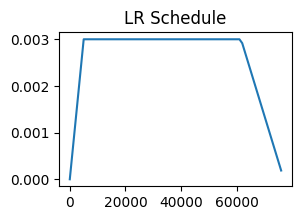

weight decay param count: 134,479,872
tokens/batch: 65,536
block size: 2048
sub-batch size: 32
no. gradient accumulation steps: 1
effective batch size per device:  32
effective batch size: 32
max steps: 76,966


In [6]:
import dataclasses

import optax


############################
# Nvidia A100 (x 8) Config #
############################

@dataclasses.dataclass
class TrainerConfig:
  num_tokens_per_batch: int = 2**16 
  mB: int = 32
  T: int = 2048
  max_steps: int = int((2_335_220*270) // (2**13))
  max_lr: float = 3e-3
  min_lr: float = max_lr * 0.1
  max_grad_norm: float = 1.0  # Clip gradients to this norm
  warmup_steps: int = 5000
  print_interval: int = 20
  eval_interval: int = 5000
  checkpoint_interval: int = 10000
  grad_accumulation_steps: int = num_tokens_per_batch // (mB * T * num_devices) # Number of steps over which to average the gradient


##############
# CPU Config #
##############

trconf = TrainerConfig()
'''
trconf = TrainerConfig(
  num_tokens_per_batch=2**9,
  mB=2**4,
  T=2**5,
  max_steps=9*48, # 6 epoch(s)
  max_lr=6e-4,
  min_lr=6e-5,
  max_grad_norm=1.0,
  warmup_steps=10,
  print_interval=1,
  eval_interval=50,
  checkpoint_interval=0,

)
'''

trconf.grad_accumulation_steps =  trconf.num_tokens_per_batch // (trconf.mB * trconf.T * num_devices) # Number of steps over which to average the gradient

# Set up the optimizer
def trapezoidal_schedule(step):

    warmup_lr = trconf.max_lr * (step + 1) / trconf.warmup_steps
    cooldown_lr = trconf.max_lr * (trconf.max_steps - step) / (trconf.max_steps - 0.8 * trconf.max_steps)

    return jnp.where(step < trconf.warmup_steps,
                     warmup_lr,
                     jnp.where(step < 0.8 * trconf.max_steps, trconf.max_lr, cooldown_lr))

steps = range(0, trconf.max_steps, 1000)
total_schedule = [ trapezoidal_schedule(step) for step in steps ]
import matplotlib.pyplot as plt
plt.figure(figsize=(3,2))
plt.plot(steps, total_schedule)
plt.title("LR Schedule")
plt.show()

# Generate a weight decay mask
# First split the model into params and variables
graphdef, params, variables = nnx.split(m, nnx.Param, nnx.Variable)
# Then create a mask for the weight decay params
weight_decay_mask = jax.tree_util.tree_map(lambda x: len(x.shape) > 1, params)

tx = optax.chain(
    #optax.clip_by_global_norm(trconf.max_grad_norm),
    optax.adamw(trapezoidal_schedule, b1=0.9, b2=0.95, weight_decay=0.1, mask=weight_decay_mask),
)
optimizer = nnx.Optimizer(m, tx)

# count the number of weight decay params
def f(x, y):
    if x:
        return y.size
    return 0

weight_decay_params = jax.tree_util.tree_map(f, weight_decay_mask, params)
weight_decay_param_count = jax.tree_util.tree_reduce(lambda x, y: x + y, weight_decay_params, 0)


print(f"weight decay param count: {weight_decay_param_count:,}")
print(f"tokens/batch: {trconf.num_tokens_per_batch:,}")
print(f"block size: {trconf.T}")
print(f"sub-batch size: {trconf.mB}")
print(f"no. gradient accumulation steps: {trconf.grad_accumulation_steps}")
print(f"effective batch size per device: ", trconf.grad_accumulation_steps * trconf.mB)
print(f"effective batch size: {trconf.grad_accumulation_steps * trconf.mB * num_devices}")
print(f"max steps: {trconf.max_steps:,}")


### DataLoader and Validation Setup



In [7]:
import os
from jaxpt.evals import calc_validation_loss
from jaxpt.dataloaders import SFT_CloudDataLoader
from jaxpt.train import loss_fn

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../alpha-448101-282bc1b884cd.json"

train_dl = SFT_CloudDataLoader(bucket_name="jaxpt_datasets",
                            bucket_prefix="webinstruct-sub/processed",
                            batch_size=trconf.mB,
                            block_size=trconf.T,
                            device_rank=num_devices,
                            label="train",
                            quiet=True)

eval_dl = SFT_CloudDataLoader(bucket_name="jaxpt_datasets",
                     bucket_prefix="webinstruct-sub/processed",
                     batch_size=trconf.mB,
                     block_size=trconf.T,
                     device_rank=1,
                     label="valid",
                     quiet=True)

def evaluate(model):
  model.eval()
  completions = generate_completions(model)
  val_loss = calc_validation_loss(model, loss_fn=loss_fn, dataloader=eval_dl)
  model.train()
  return val_loss, completions


In [9]:
from jaxpt.utils import append_to_csv

train_losses = []
append_to_csv(log_dir / f"{run_dirname}_train.csv", ["step", "lr", "loss", "norm", "time", "tokens_processed", "tokens_per_sec"])
step = 0

In [ ]:
%matplotlib inline

import time

import matplotlib.pyplot as plt

from jaxpt.train import parallel_train_step

m.train()
try:
  while step < trconf.max_steps:
    start = time.time()
    batch, target, attn_mask, label_mask = train_dl()
    avg_loss, avg_grads = parallel_train_step(m, optimizer, batch, target, attn_mask, label_mask)
    avg_loss.block_until_ready()
    # compute stats
    avg_loss = jax.device_get(avg_loss)
    avg_loss = jnp.float32(avg_loss[0])
    lr = trapezoidal_schedule(step)
    norm = 0 # norm[0]|
    iter_time = time.time() - start
    sub_step_time = iter_time / trconf.grad_accumulation_steps
    tokens_per_sec = num_devices * trconf.mB * trconf.T * trconf.grad_accumulation_steps / iter_time
    tokens_processed = (step+1) * num_devices * trconf.grad_accumulation_steps * trconf.mB * trconf.T

    if step % trconf.print_interval == 0:
      train_losses.append((step, avg_loss))
      append_to_csv(log_dir / f"{run_dirname}_train.csv", [step, lr, avg_loss, norm, iter_time*1000, tokens_processed, tokens_per_sec])
      print(f"{step} | lr: {lr:0.2e} | "
            f"loss: {avg_loss:0.4f} | "
            f"time: {iter_time*1000:0.2f}ms | "
            f"tokens processed: {tokens_processed:,} | "
            f"tok/sec: {tokens_per_sec:,.2f}", end="\r")
    if step % trconf.eval_interval == 0:
      print("Evaluation TBD")
      save_checkpoint(m, run_dirname, step)
    step += 1

except KeyboardInterrupt:
    print("Received KeyboardInterrupt. Exiting...")

plt.figure(figsize=(5, 3))
plt.plot([x[0] for x in train_losses], [x[1] for x in train_losses], label="train loss")
plt.legend()
plt.savefig(log_dir / f"{run_dirname}.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()


In [ ]:
completions = generate_completions(m, enc=tokenizer, max_length=40)
for completion in completions:
    print(completion)